In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!pip uninstall opencv-python -y

!pip install opencv-contrib-python==3.4.2.17 --force-reinstall


Uninstalling opencv-python-4.1.2.30:
  Successfully uninstalled opencv-python-4.1.2.30
     |████████████████████████████████| 30.6MB 108kB/s 
     |████████████████████████████████| 20.2MB 1.3MB/s 
ERROR: imgaug 0.2.9 requires opencv-python, which is not installed.
ERROR: dopamine-rl 1.0.5 requires opencv-python>=3.4.1.15, which is not installed.
ERROR: albumentations 0.1.12 requires opencv-python, which is not installed.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.4
    Uninstalling numpy-1.18.4:
      Successfully uninstalled numpy-1.18.4
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [1]:
pip install --upgrade neural_structured_learning

     |████████████████████████████████| 112kB 3.4MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# #making a directory ciphar_dataset from .tar/gz file
# import tarfile
# with tarfile.open('/content/drive/My Drive/SML_Project_neural_graph_machines/cifar-10-python.tar.gz', 'r:gz') as tar:
#     tar.extractall("/content/drive/My Drive/SML_Project_neural_graph_machines/ciphar_dataset")

In [0]:
#importing all library for project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import cv2
from sklearn.decomposition import PCA
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from xgboost import XGBClassifier
from skimage.feature import hog, local_binary_pattern
import sklearn.preprocessing as prp
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import neural_structured_learning as nsl
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [0]:
#LOAD DATASET CIPHAR10 from directory and return train data,train label,test data,test label and filenames
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
def load_cifar_10_data(data_dir, negatives=False):
   
    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []


    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_filenames, cifar_train_labels, \
        cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names

In [0]:
#FEATURE EXTRACTION
#FEATURE EXTRACTION TECHNIQUES such as Color Histogram ,HOG,SURF,SIFT
def get_color_hist(images, name='color_hist'):
    histograms = []
    for img in images:
        histograms.append(cv2.calcHist([img], [0, 1, 2],None, [8, 8, 8], [0, 256, 0, 256, 0, 256]).flatten())
    
    result = np.array(histograms)
    return result

def get_hog(train_images_temp,test_images_temp,name='hog'):
  hog_features_train=[]
  hog_features_test=[]
  for i in range(0,len(train_images_temp)):
      fd = hog(train_images_temp[i],block_norm='L2')
      hog_features_train.append(fd)
 

  for i in range(0,len(test_images_temp)):
      fd = hog(test_images_temp[i],block_norm='L2')
      hog_features_test.append(fd)

  hog_features_train=np.array(hog_features_train)
  hog_features_test=np.array(hog_features_test)

  return hog_features_train,hog_features_test

def get_surf(images, name='surf', save=False):
    # SURF descriptor for 1 image
    def get_image_surf(image, vector_size=8):
        alg = cv2.xfeatures2d.SURF_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 64
        needed_size = (vector_size * 64)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SURF descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_surf(img)
        features.append(dsc)
    
    result = np.array(features)
        
    return result

def get_sift(images, name='sift'):
    # SIFT descriptor for 1 image
    def get_image_sift(image, vector_size=8):
        alg = cv2.xfeatures2d.SIFT_create()
        kps = alg.detect(image, None)
        kps = sorted(kps, key=lambda x: -x.response)[:vector_size]
        
        # Making descriptor of same size
        # Descriptor vector size is 128
        needed_size = (vector_size * 128)
        if len(kps) == 0:
            return np.zeros(needed_size)
        
        kps, dsc = alg.compute(image, kps)
        dsc = dsc.flatten()
        if dsc.size < needed_size:
            # if we have less than 32 descriptors then just adding zeros at the
            # end of our feature vector
            dsc = np.concatenate([dsc, np.zeros(needed_size - dsc.size)])
            
        return dsc
    
    # SIFT descriptor for all images
    features = []
    for i, img in enumerate(images):
        dsc = get_image_sift(img)
        features.append(dsc)

    result = np.array(features)
        
    return result

(50000, 32, 32)
(50000, 3072)
[b'airplane' b'automobile' b'bird' b'cat' b'deer' b'dog' b'frog' b'horse'
 b'ship' b'truck']
b'airplane'


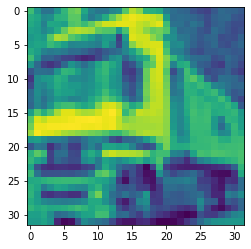

In [7]:
#Load Data and Visualization and Preprocessing
cifar_10_dir = '/content/drive/My Drive/SML_Project_neural_graph_machines/ciphar_dataset/cifar-10-batches-py'
train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = load_cifar_10_data(cifar_10_dir)
train_data_gray=[cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) for img in train_data]
test_data_gray=[cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) for img in test_data]
train_data_flatten=train_data.reshape(train_data.shape[0],train_data.shape[1]*train_data.shape[2]*train_data.shape[3])
test_data_flatten=test_data.reshape(test_data.shape[0],test_data.shape[1]*test_data.shape[2]*test_data.shape[3])
train_data_gray=np.array(train_data_gray)
test_data_gray=np.array(test_data_gray)
print(train_data_gray.shape)
plt.imshow(train_data_gray[1])
print(train_data_flatten.shape)
print(label_names)
train_data=train_data.astype('float32')
test_data=test_data.astype('float32')
train_data=train_data/255.0
test_data=test_data/255.0

print((label_names[0]))

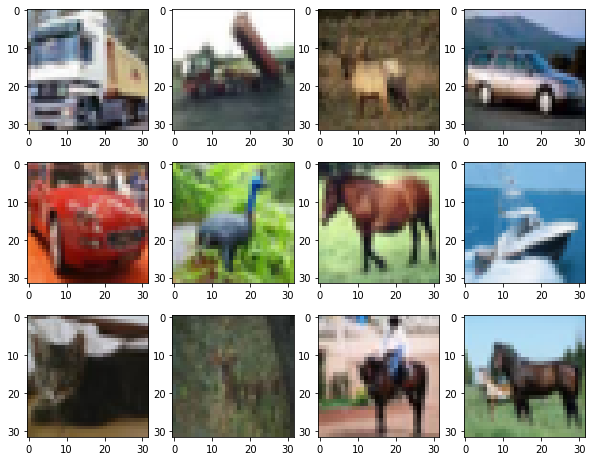

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


In [8]:
#Data Visualization
w=10
h=10
fig=plt.figure(figsize=(10, 8))
columns = 4
rows = 3
for i in range(1, columns*rows +1):
    img = train_data[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()
counter=Counter(train_labels)
print(counter)

In [9]:
    #Shapes of all data (training,testing,labels)
    print("Train data: ", train_data.shape)
    print("Train filenames: ", train_filenames.shape)
    print("Train labels: ", train_labels.shape)
    print("Test data: ", test_data.shape)
    print("Test filenames: ", test_filenames.shape)
    print("Test labels: ", test_labels.shape)
    print("Label names: ", label_names.shape)
    print(train_labels[:])

Train data:  (50000, 32, 32, 3)
Train filenames:  (50000,)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test filenames:  (10000,)
Test labels:  (10000,)
Label names:  (10,)
[6 9 9 ... 9 1 1]


In [0]:
train_data_hist=get_color_hist(train_data)
test_data_hist=get_color_hist(test_data)
train_data_hog,test_data_hog=get_hog(train_data_gray,test_data_gray)
train_data_sift=get_sift(train_data_gray)
test_data_sift=get_sift(test_data_gray)
train_data_surf=get_sift(train_data_gray)
test_data_surf=get_sift(test_data_gray)
print(train_data_hist.shape)
print(train_data_hog.shape)
print(train_data_sift.shape)
print(train_data_surf.shape)

(50000, 512)
(50000, 324)
(50000, 1024)
(50000, 1024)


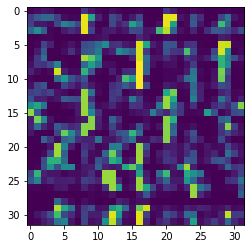

In [0]:
plt.imshow(train_data_sift[1].reshape(32,32))

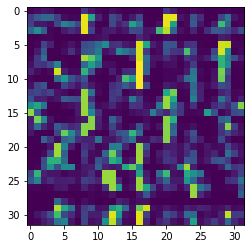

In [0]:
plt.imshow(train_data_surf[1].reshape(32,32))

In [0]:
X_train,X_test,y_train,y_test=train_test_split(train_data,train_labels,test_size=0.2,random_state=42)

In [0]:
model=RandomForestClassifier()
model.fit(train_data_hist,train_labels)
print(model.score(test_data_hist,test_labels))
model=RandomForestClassifier()
model.fit(train_data_hog,train_labels)
print(model.score(test_data_hog,test_labels))
model=RandomForestClassifier()
model.fit(train_data_sift,train_labels)
print(model.score(test_data_sift,test_labels))
model=RandomForestClassifier()
model.fit(train_data_surf,train_labels)
print(model.score(test_data_surf,test_labels))

0.1
0.5093
0.2259
0.2313


In [0]:
model=SVC()
model.fit(X_train,y_train)
print(model.score(X_test,y_test))


0.4074


In [0]:
# model=RandomForestClassifier()
# model.fit(train_data.reshape(50000,3072),train_labels)
print(model.score(test_data.reshape(10000,3072),test_labels))

0.4741


In [0]:
#history=model.fit(train_data,train_labels,validation_data=(test_data,test_labels),epochs=15)

In [10]:
import sys
import tensorflow as tf
from matplotlib import pyplot
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD

Using TensorFlow backend.


In [0]:
train_labels_cat=to_categorical(train_labels)
test_labels_cat=to_categorical(test_labels)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#1VGG BLOCK
def base_model_func1():
  inputs=keras.Input(shape=(32,32,3),dtype=tf.float32,name=IMAGE_INPUT_NAME)
  x=inputs
  x=keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x=keras.layers.MaxPooling2D((2,2))(x)
  x=keras.layers.Flatten()(x)
  x=keras.layers.Dense(128,activation='relu')(x)
  output=keras.layers.Dense(10,activation='softmax')(x)
  model=keras.Model(inputs=inputs,outputs=output,name='cifar10_basemodel_1VGG')
  return model

#2VGG BLOCK
def base_model_func2():
  inputs=keras.Input(shape=(32,32,3),dtype=tf.float32,name=IMAGE_INPUT_NAME)
  x=inputs
  x=keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x=keras.layers.MaxPooling2D((2,2))(x)
  x=keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x=keras.layers.MaxPooling2D((2,2))(x)
  x=keras.layers.Flatten()(x)
  x=keras.layers.Dense(128,activation='relu')(x)
  output=keras.layers.Dense(10,activation='softmax')(x)
  model=keras.Model(inputs=inputs,outputs=output,name='cifar10_basemodel_2VGG')
  return model

#3VGG BLOCK
def base_model_func3():
  inputs=keras.Input(shape=(32,32,3),dtype=tf.float32,name=IMAGE_INPUT_NAME)
  x=inputs
  x=keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(32,(3,3),activation='relu')(x)
  x=keras.layers.MaxPooling2D((2,2))(x)
  x=keras.layers.Dropout(0.2)(x)
  x=keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(64,(3,3),activation='relu')(x)
  x=keras.layers.MaxPooling2D((2,2))(x)
  x=keras.layers.Dropout(0.2)(x)
  x=keras.layers.Conv2D(128,(3,3),activation='relu')(x)
  x=keras.layers.Conv2D(128,(3,3),activation='relu')(x)
  x=keras.layers.Dropout(0.2)(x)
  #x=keras.layers.MaxPooling2D((2,2))(x)  
  x=keras.layers.Flatten()(x)
  x=keras.layers.Dense(128,activation='relu')(x)
  x=keras.layers.Dropout(0.2)(x)
  output=keras.layers.Dense(10,activation='softmax')(x)
  model=keras.Model(inputs=inputs,outputs=output,name='cifar10_basemodel_3VGG')
  return model


In [0]:
def convert_to_tuples(features):
  return features[IMAGE_INPUT_NAME], features[LABEL_INPUT_NAME]

def convert_to_dictionaries(image, label):
  return {IMAGE_INPUT_NAME: image, LABEL_INPUT_NAME: label}
  

In [41]:
IMAGE_INPUT_NAME = 'image'
LABEL_INPUT_NAME = 'label'
# base_model = build_base_model(HPARAMS)
# base_model.summary()

base_model=base_model_func3()
base_model.summary()
#opt = SGD(lr=0.001, momentum=0.9)
es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=18)#early stopping
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)#saving best model
base_model.compile(optimizer='sgd', loss='categorical_crossentropy',
                   metrics=['accuracy'])
first_nn_fitted=base_model.fit(train_data,train_labels_cat,validation_data=(test_data,test_labels_cat), epochs=100,verbose=1,callbacks=[es,mc])

# base_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# history=base_model.fit(train_data,train_labels,validation_data=(test_data,test_labels),epochs=5,verbose=1)

Model: "cifar10_basemodel_3VGG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 10, 10, 

In [47]:
# predict probabilities for test set
yhat_probs = base_adv_model.predict(test_data, verbose=0)
# predict crisp classes for test set
yhat_classes=np.argmax(yhat_probs,axis=1)
#yhat_classes = base_model.predict_classes(test_data, verbose=0)
test_labels_temp = np.array(test_labels, dtype=np.int)

precision = precision_score(test_labels_temp.flatten(), yhat_classes.flatten(),average='macro')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(test_labels_temp.flatten(), yhat_classes.flatten(),average='macro')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(test_labels_temp.flatten(), yhat_classes.flatten(),average='macro')
print('F1 score: %f' % f1)

Precision: 0.797437
Recall: 0.793800
F1 score: 0.794948


In [45]:
#NEURAL GRAPH MACHINES USING NSL Framework
adv_config = nsl.configs.make_adv_reg_config(
    multiplier=0.2,
    adv_step_size=0.01
)
#defined config of graph network
base_adv_model = base_model_func3()

#base_adv_model = build_base_model(HPARAMS)
adv_model = nsl.keras.AdversarialRegularization(
    base_adv_model,
    label_keys=[LABEL_INPUT_NAME],
    adv_config=adv_config
)
#building adversarial nework using base and graphs

train_set_for_adv_model = convert_to_dictionaries(train_data,train_labels_cat)
test_set_for_adv_model = convert_to_dictionaries(test_data,test_labels_cat)
print(len(train_set_for_adv_model[IMAGE_INPUT_NAME]))
#print((test_set_for_adv_model))

50000


In [46]:
#Training adversarial network 
# adv_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
#                    metrics=['acc'])

es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=18)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_categorical_accuracy', mode='max', verbose=1, save_best_only=True)
adv_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
second_nn_fitted=adv_model.fit(train_set_for_adv_model,validation_data=test_set_for_adv_model, epochs=100,callbacks=[es,mc])

# train_labels_cat=np.array(train_labels_cat,dtype='float32')
# adv_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['acc'])
# new_model=adv_model.fit({'feature':train_data,'label':train_labels_cat},epochs=10,verbose=1)


Epoch 1/100
1560/1563 [============================>.] - ETA: 0s - loss: 2.6130 - categorical_crossentropy: 2.1774 - categorical_accuracy: 0.1815 - adversarial_loss: 2.1776
Epoch 00001: val_categorical_accuracy improved from -inf to 0.28080, saving model to best_model.h5
1563/1563 [==============================] - 31s 20ms/step - loss: 2.6127 - categorical_crossentropy: 2.1773 - categorical_accuracy: 0.1816 - adversarial_loss: 2.1774 - val_loss: 2.3923 - val_categorical_crossentropy: 1.9929 - val_categorical_accuracy: 0.2808 - val_adversarial_loss: 1.9968
Epoch 2/100
1561/1563 [============================>.] - ETA: 0s - loss: 2.3238 - categorical_crossentropy: 1.9361 - categorical_accuracy: 0.2823 - adversarial_loss: 1.9383
Epoch 00002: val_categorical_accuracy improved from 0.28080 to 0.37210, saving model to best_model.h5
1563/1563 [==============================] - 30s 19ms/step - loss: 2.3238 - categorical_crossentropy: 1.9361 - categorical_accuracy: 0.2823 - adversarial_loss: 1.

In [51]:
results = adv_model.evaluate(test_set_for_adv_model)
named_results = dict(zip(adv_model.metrics_names, results))
print('\naccuracy:', named_results['categorical_accuracy'])

313/313 [==============================] - 4s 14ms/step - loss: 0.8574 - categorical_crossentropy: 0.7023 - categorical_accuracy: 0.7938 - adversarial_loss: 0.7754

accuracy: 0.7937999963760376


In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

base_model.evaluate(test_data,test_labels_cat)

313/313 [==============================] - 2s 6ms/step - loss: 0.7841 - accuracy: 0.7644


[0.7841242551803589, 0.7644000053405762]

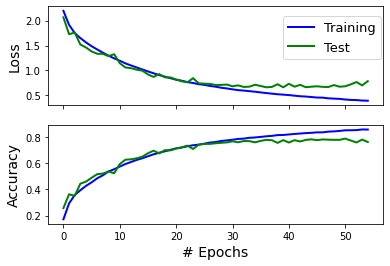

In [48]:
#PLOTTING EPOCHS VS LOSS AND ACCURCY FOR BASE MODELS
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(len(first_nn_fitted.history['loss'])), first_nn_fitted.history['loss'],linestyle='-', color='blue',label='Training', lw=2)
ax1.plot(range(len(first_nn_fitted.history['val_loss'])), first_nn_fitted.history['val_loss'], linestyle='-', color='green',label='Test', lw=2)
ax2.plot(range(len(first_nn_fitted.history['accuracy'])), first_nn_fitted.history['accuracy'],linestyle='-', color='blue',label='Training', lw=2)
ax2.plot(range(len(first_nn_fitted.history['val_accuracy'])), first_nn_fitted.history['val_accuracy'], linestyle='-', color='green',label='Test', lw=2)
leg = ax1.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0.,fontsize=13)
ax1.set_xticklabels('')
#ax1.set_yscale('log')
ax2.set_xlabel('# Epochs',fontsize=14)
ax1.set_ylabel('Loss',fontsize=14)
ax2.set_ylabel('Accuracy',fontsize=14)
plt.show()

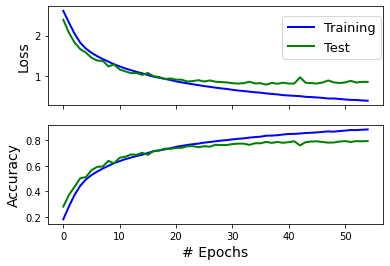

In [49]:
#PLOTTING EPOCHS VS LOSS AND ACCURCY FOR NEURAL GRAPH MACHINES MODELS
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(range(len(second_nn_fitted.history['loss'])), second_nn_fitted.history['loss'],linestyle='-', color='blue',label='Training', lw=2)
ax1.plot(range(len(second_nn_fitted.history['val_loss'])), second_nn_fitted.history['val_loss'], linestyle='-', color='green',label='Test', lw=2)
ax2.plot(range(len(second_nn_fitted.history['categorical_accuracy'])), second_nn_fitted.history['categorical_accuracy'],linestyle='-', color='blue',label='Training', lw=2)
ax2.plot(range(len(second_nn_fitted.history['val_categorical_accuracy'])), second_nn_fitted.history['val_categorical_accuracy'], linestyle='-', color='green',label='Test', lw=2)
leg = ax1.legend(bbox_to_anchor=(0.7, 0.9), loc=2, borderaxespad=0.,fontsize=13)
ax1.set_xticklabels('')
#ax1.set_yscale('log')
ax2.set_xlabel('# Epochs',fontsize=14)
ax1.set_ylabel('Loss',fontsize=14)
ax2.set_ylabel('Accuracy',fontsize=14)
plt.show()